In [1]:
%pylab inline
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


read geojson file of street segments in D.C. (ST DATA)

(13522, 22)


,0,1,2,3,4
BEGINMEASURE,0,0,0,0,0
DIRECTIONALITY,0,1,1,2,2
ENDMEASURE,192.9251,131.9356,117.887,108.3311,119.1903
FACILITYID,SEGID-876,SEGID-13161,SEGID-8240,SEGID-10395,SEGID-2216
FROMADDRESSLEFTTHEO,5000,5200,5300,5400,5500
FROMADDRESSRIGHTTHEO,5001,5203,5301,5401,5501
FROMNODEID,18637,20290,19814,19815,20876
OBJECTID,1,2,3,4,5
OBJECTID_1,37,38,39,40,41
QUADRANT,NW,NW,NW,NW,NW


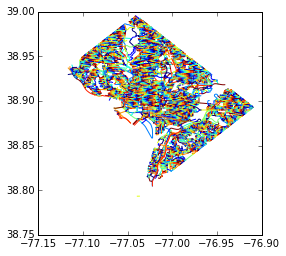

In [2]:
str_gpd = gpd.read_file('Street_Segments.geojson')
segid_in_st_data = set(pd.unique(str_gpd.STREETSEGID))
str_gpd.plot()
print str_gpd.shape
str_gpd.head().T

read geojson file of moving violation in D.C. in December 2011 (MV DATA)

(79111, 19)


,ACCIDENTINDICATOR,ADDRESS_ID,AGENCYID,FINEAMT,LOCATION,OBJECTID,PENALTY1,PENALTY2,ROW_,ROW_ID,STREETSEGID,TICKETISSUEDATE,TICKETTYPE,TOTALPAID,VIOLATIONCODE,VIOLATIONDESC,XCOORD,YCOORD,geometry
0,Yes,808248,4,25,4200 GEORGIA AVE NW,1298339,None,None,4582873,4582873,7063,2016-01-20T00:00:00,Moving,0,T107,FAIL TO YIELD RIGHT OF WAY,397783.420000,141577.140000,POINT (-77.0255705397 38.9420904331)
1,No,813891,25,100,600 blk Kenilworth Ave NE s/b,1298340,None,None,4582875,4582875,11963,2016-01-20T00:00:00,Photo,0,T119,SPEED 11-15 MPH OVER THE SPEED LIMIT,404478.832866,136788.897372,POINT (-76.94837018290001 38.8989477699)
2,No,801702,25,150,Suitland Pk w/b @ Stanton Rd SE,1298369,None,None,4583200,4583200,3557,2016-01-01T00:00:00,Photo,150,T120,SPEED 16-20 MPH OVER THE SPEED LIMIT,401449.342600,131721.086000,POINT (-76.9833049061 38.8533051238)
3,No,810381,25,100,DC295 SW .7 miles s/o Exit 1 S/B,1298370,None,None,4583204,4583204,6993,2016-01-01T00:00:00,Photo,100,T119,SPEED 11-15 MPH OVER THE SPEED LIMIT,398406.310000,127737.130000,POINT (-77.01835340300001 38.8174155704)
4,No,904857,25,100,New York Ave sw/b @ Florida Ave NE,1298371,100,None,4583207,4583207,5265,2016-01-01T00:00:00,Photo,0,T119,SPEED 11-15 MPH OVER THE SPEED LIMIT,399601.653054,137892.960573,POINT (-77.00459507879999 38.9089048795)


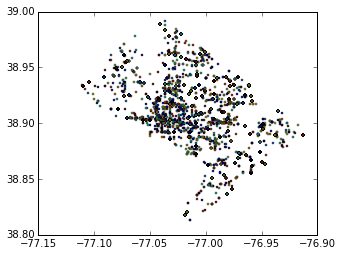

In [3]:
mvio_gpd = gpd.read_file('Moving_Violations_in_January_2016.geojson')
mvio_gpd.plot()
print mvio_gpd.shape
mvio_gpd.head()

create buffer for both lineString(segment) and point(violation)

Note that the unit of buffer here is not distance unit, like meter/mile. The appropiate buffer is still undecided.

For simplicity, other attributes are omitted

In [4]:
for buf in [0.00005,0.0001,0.0005, 0.001]:
    print 'buffer = %f' % buf
    str_bfr_gpd = str_gpd[['OBJECTID','STREETSEGID','geometry']].copy()
    str_bfr_gpd.geometry = str_bfr_gpd.buffer(buf)
    mvio_bfr_gpd = mvio_gpd[['OBJECTID','STREETSEGID','geometry','TICKETISSUEDATE','TICKETTYPE']].copy()
    mvio_bfr_gpd.geometry = mvio_bfr_gpd.buffer(buf)
    joined = sjoin(mvio_bfr_gpd, str_bfr_gpd, how='left', op='intersects')
    gb = joined.reset_index().groupby('OBJECTID_left').count()
    
    print '%d points spatially match no segment' % gb[gb.OBJECTID_right==0].shape[0]
    print '%d points spatially match 1 segment' % gb[gb.OBJECTID_right==1].shape[0]
    print '%d points spatially match multiple segments' % gb[gb.OBJECTID_right>1].shape[0]

buffer = 0.000050
14152 points spatially match no segment
52362 points spatially match 1 segment
12597 points spatially match multiple segments
buffer = 0.000100
11735 points spatially match no segment
33934 points spatially match 1 segment
33442 points spatially match multiple segments
buffer = 0.000500
793 points spatially match no segment
9497 points spatially match 1 segment
68821 points spatially match multiple segments
buffer = 0.001000
0 points spatially match no segment
4916 points spatially match 1 segment
74195 points spatially match multiple segments


use buffer 0.0001 as an example

In [5]:
str_bfr_gpd = str_gpd[['OBJECTID','STREETSEGID','geometry']].copy()
str_bfr_gpd.geometry = str_bfr_gpd.buffer(0.0001)
mvio_bfr_gpd = mvio_gpd[['OBJECTID','STREETSEGID','geometry','TICKETISSUEDATE','TICKETTYPE']].copy()
mvio_bfr_gpd.geometry = mvio_bfr_gpd.buffer(0.0001)

op: ['contains', 'within', 'intersects']

how: ['left', 'right', 'inner']
 
how='left', op='intersects' means that polygons/points in the left dataframe intersects with which one(s) in the right. The geometry in the new dataframe is from the left.

In [6]:
joined = sjoin(mvio_bfr_gpd, str_bfr_gpd, how='left', op='intersects')
gb = joined.reset_index().groupby('OBJECTID_left').count()
print '%d points spatially match no segment' % gb[gb.OBJECTID_right==0].shape[0]
print '%d points spatially match 1 segment' % gb[gb.OBJECTID_right==1].shape[0]
print '%d points spatially match multiple segments' % gb[gb.OBJECTID_right>1].shape[0]
joined.head()

11735 points spatially match no segment
33934 points spatially match 1 segment
33442 points spatially match multiple segments


,OBJECTID_left,STREETSEGID_left,geometry,TICKETISSUEDATE,TICKETTYPE,index_right,OBJECTID_right,STREETSEGID_right
0,1298339,7063,"POLYGON ((-77.0254705397 38.9420904331, -77.02...",2016-01-20T00:00:00,Moving,2157,2158,7063
0,1298339,7063,"POLYGON ((-77.0254705397 38.9420904331, -77.02...",2016-01-20T00:00:00,Moving,2926,2927,12244
1,1298340,11963,"POLYGON ((-76.9482701829 38.8989477699, -76.94...",2016-01-20T00:00:00,Photo,9313,9314,11963
1,1298340,11963,"POLYGON ((-76.9482701829 38.8989477699, -76.94...",2016-01-20T00:00:00,Photo,9260,9261,5134
2,1298369,3557,"POLYGON ((-76.9832049061 38.8533051238, -76.98...",2016-01-01T00:00:00,Photo,12493,12494,6006


In [7]:
def get_mvio_bfr_by_objid(mvio_bfr_gpd, mvio_objid):
    return mvio_bfr_gpd[mvio_bfr_gpd.OBJECTID==mvio_objid]

def get_str_bfr_by_mvio_objid_thru_joined(str_bfr_gpd, joined, mvio_objid):
    SERIES_STREETSEGID = joined[joined.OBJECTID_left==mvio_objid].STREETSEGID_right
    return str_bfr_gpd[str_bfr_gpd.STREETSEGID.isin(SERIES_STREETSEGID)]

def get_str_bfr_by_seg_id(str_bfr_gpd, seg_id):
    return str_bfr_gpd[str_bfr_gpd.STREETSEGID==seg_id]

def plot_mv_and_intersected_seg(mvio_bfr_gpd,str_bfr_gpd,joined,mvio_objid, buf=0.0001):
    mv = get_mvio_bfr_by_objid(mvio_bfr_gpd,mvio_objid)[['OBJECTID','STREETSEGID','geometry']]
    mv.geometry = mv.buffer(buf)
    st_matched_mv = get_str_bfr_by_mvio_objid_thru_joined(str_bfr_gpd, joined, mvio_objid)

    mg = mv.append(st_matched_mv)
    mg.iloc[0,0]= str(mg.iloc[0,0])+'POINT'
    mg.plot()
    return mg

def get_mv_and_seg_in_mv(str_bfr_gpd,mvio_bfr_gpd,mvio_objid):
    mv = get_mvio_bfr_by_objid(mvio_bfr_gpd,mvio_objid)[['OBJECTID','STREETSEGID','geometry']]
    segid = list(mv.STREETSEGID)[0]
    if math.isnan(segid):
        mg = mv
    else:
        st_in_mv = get_str_bfr_by_seg_id(str_bfr_gpd, segid)
        mg = mv.append(st_in_mv)
    return mg

Examples in points that spatially match no segment(Non-match group)

In [8]:
joined_None = joined[joined.OBJECTID_left.isin(gb[gb.OBJECTID_right==0].index)]
joined_None.shape

(11735, 8)

In [9]:
mvio_objid_with_nan_segid = []
not_in_st_data = set()
for i in range(joined_None.shape[0]):
    mvio_objid = joined_None.iloc[i].OBJECTID_left
    mv = get_mvio_bfr_by_objid(mvio_bfr_gpd,mvio_objid)[['OBJECTID','STREETSEGID','geometry']]
    segid = list(mv.STREETSEGID)[0]
#     print i, mvio_objid, segid, segid in segid_in_st_data
    if math.isnan(segid):
        mvio_objid_with_nan_segid.append(mvio_objid)
    elif not segid in segid_in_st_data:
        not_in_st_data.add(segid)
            
if not_in_st_data.__len__()==0:
    print 'all streetsegids in Non-Match group is in ST DATA, expect for those MV without any segid'
else: 
    print not_in_st_data
    
print '%d mv points have no segid' % len(mvio_objid_with_nan_segid)

all streetsegids in Non-Match group is in ST DATA, expect for those MV without any segid
2360 mv points have no segid


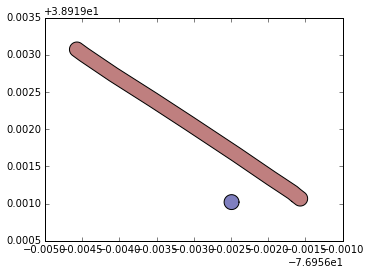

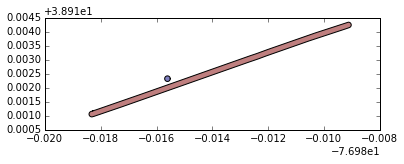

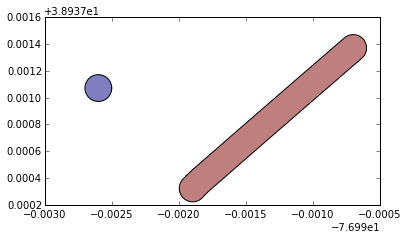

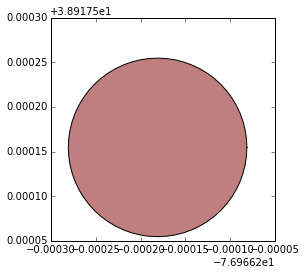

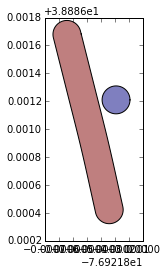

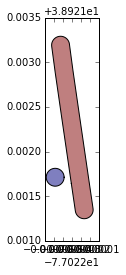

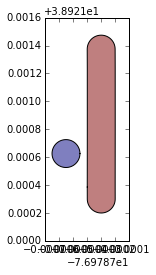

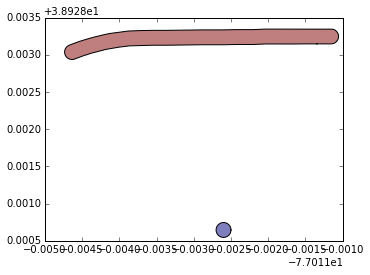

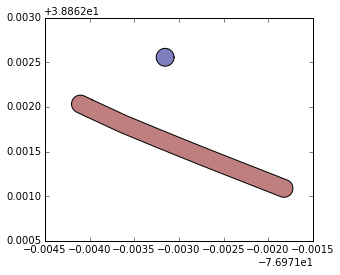

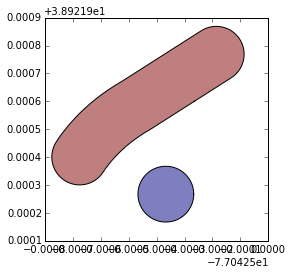

In [10]:
temp = joined_None[~joined_None.duplicated('STREETSEGID_left')]
for i in range(10):
    mvio_objid = temp.iloc[i].OBJECTID_left
    mg = get_mv_and_seg_in_mv(str_bfr_gpd,mvio_bfr_gpd,mvio_objid)
    mg.plot()

Examples in points that spatially match single segments

In [11]:
joined_single = joined[joined.OBJECTID_left.isin(gb[gb.OBJECTID_right==1].index)]

,OBJECTID,STREETSEGID,geometry
3,1298370POINT,6993,POLYGON ((-77.01815352345439 38.81742047716747...
11846,11847,6993,POLYGON ((-77.02257353340049 38.80463881806454...


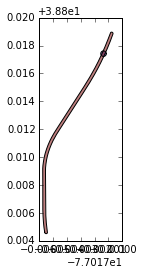

In [12]:
mvio_objid = joined_single.iloc[0].OBJECTID_left
mg = plot_mv_and_intersected_seg(mvio_bfr_gpd, str_bfr_gpd, joined_single, mvio_objid)
mg

Examples in points that spatially match multiple segments

In [13]:
joined_mult = joined[joined.OBJECTID_left.isin(gb[gb.OBJECTID_right>1].index)]
mvio_has_same_seg = joined_mult[joined_mult.STREETSEGID_left==joined_mult.STREETSEGID_right].OBJECTID_left
mvio_no_same_seg = pd.unique(joined_mult[~joined_mult.OBJECTID_left.isin(mvio_has_same_seg)].OBJECTID_left)
print '%d points spatially match multiple segments' % pd.unique(joined_mult.OBJECTID_left).shape
print '%d points\' segmentid match one record in ST DATA' % mvio_has_same_seg.shape
print '%d points\' segmentid does not match any record' % mvio_no_same_seg.shape

33442 points spatially match multiple segments
32952 points' segmentid match one record in ST DATA
490 points' segmentid does not match any record


,OBJECTID,STREETSEGID,geometry
458,1304315POINT,5134,POLYGON ((-76.93392108504381 38.91138451467475...
9258,9259,3727,POLYGON ((-76.95805768085084 38.88997175019537...
9260,9261,5134,POLYGON ((-76.95491079643887 38.89317993393837...
9366,9367,3424,POLYGON ((-76.93531016750976 38.91139065011738...


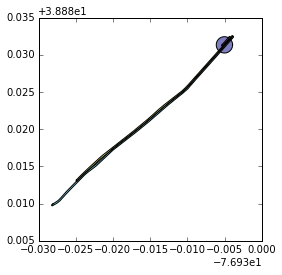

In [21]:
mvio_objid = list(mvio_has_same_seg)[197]  
mg = plot_mv_and_intersected_seg(mvio_bfr_gpd, str_bfr_gpd, joined_mult, mvio_objid,buf=0.001)
mg

,OBJECTID,STREETSEGID,geometry
2342,1268286POINT,3664,POLYGON ((-76.91318847775438 38.88976262126747...
8064,8065,7741,POLYGON ((-76.91339182082952 38.88988240671558...
12414,12415,4932,"POLYGON ((-76.9135272737995 38.88986390214127,..."
12415,12416,3664,POLYGON ((-76.91326426292154 38.88984650488342...
13199,13200,6227,POLYGON ((-76.91441437556338 38.88908027416737...


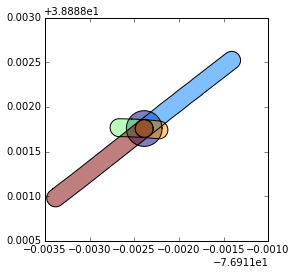

In [20]:
mvio_objid = list(mvio_has_same_seg)[1000]                             
mg = plot_mv_and_intersected_seg(mvio_bfr_gpd, str_bfr_gpd, joined_mult, mvio_objid)
mg

,OBJECTID,STREETSEGID,geometry
14,1298381POINT,5134,POLYGON ((-76.94924773724381 38.89724414957475...
9258,9259,3727,POLYGON ((-76.95805768085084 38.88997175019537...
9260,9261,5134,POLYGON ((-76.95491079643887 38.89317993393837...
9312,9313,1272,POLYGON ((-76.95182234201812 38.89632348735134...


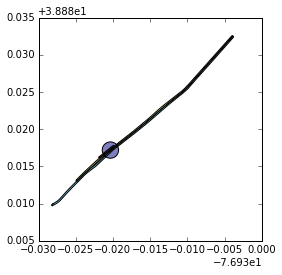

In [16]:
mvio_objid = list(mvio_has_same_seg)[10]
mg = plot_mv_and_intersected_seg(mvio_bfr_gpd, str_bfr_gpd, joined_mult, mvio_objid, buf=0.001)
mg

In [17]:
'The reason why 44 points in MV DATA have no match is that their streetsegids %s are not in ST DATA' % str(
    list(pd.unique(mvio_gpd[mvio_gpd.OBJECTID.isin(mvio_no_same_seg)].STREETSEGID)))

'The reason why 44 points in MV DATA have no match is that their streetsegids [2731.0, 21.0, 15302.0, 1330.0, 4201.0, 227.0, 100.0, 2497.0, 5774.0, 3372.0] are not in ST DATA'

The streesegid 2731 in moving violation is not in the Street Segment GeoJSON
Empty GeoDataFrame
Columns: [OBJECTID, STREETSEGID, geometry]
Index: []


,OBJECTID,STREETSEGID,geometry
505,1304732POINT,2731,POLYGON ((-77.02781262735438 38.96127176596747...
2267,2268,10603,POLYGON ((-77.02812915025781 38.96107379343902...
4912,4913,9523,POLYGON ((-77.02837898666121 38.96121820837006...
13369,13370,15302,POLYGON ((-77.02810768577236 38.96132692111525...


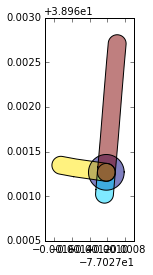

In [18]:
mvio_objid = list(mvio_no_same_seg)[0]
mv = get_mvio_bfr_by_objid(mvio_bfr_gpd,mvio_objid)[['OBJECTID','STREETSEGID','geometry']]
print 'The streesegid %d in moving violation is not in the Street Segment GeoJSON' % list(mv.STREETSEGID)[0]
st_in_mv = get_str_bfr_by_seg_id(str_bfr_gpd, list(mv.STREETSEGID)[0])
print st_in_mv
st_matched_mv = get_str_bfr_by_mvio_objid_thru_joined(str_bfr_gpd, joined_mult, mvio_objid)

mg = plot_mv_and_intersected_seg(mvio_bfr_gpd, str_bfr_gpd, joined_mult, mvio_objid)
mg
